In [1]:
import numpy as np
from sklearn.decomposition import PCA
import torch
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

In [ ]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

train_set_x = mnist_trainset.data.numpy()
test_set_x = mnist_testset.data.numpy()
train_set_y = mnist_trainset.targets.numpy()
test_set_y = mnist_testset.targets.numpy()

# We choose only images with 0 or 1 label using masking. Then we flatten our data using .reshape()
mask_train = [(train_set_y == 1) | (train_set_y == 0)]
mask_test = [(test_set_y == 1) | (test_set_y == 0)]

train_set_x = train_set_x[mask_train].reshape(-1, 784)
test_set_x = test_set_x[mask_test].reshape(-1, 784)
train_y = train_set_y[mask_train]
test_y = test_set_y[mask_test]

In [39]:
def transform(train_data, test_data, n_pca=2, scale = True):
    """
    Applying PCA and MinMaxScaler
    """
    pca = PCA(n_components=n_pca)
    tr_data = pca.fit_transform(train_data)
    ts_data = pca.transform(test_data)
    if scale:
      min = tr_data.min(axis=0)
      max = tr_data.max(axis=0)
      tr_data = (tr_data - min) / (max - min)
      ts_data = (ts_data - min) / (max - min)
    return tr_data, ts_data

def error(y_test, y_pred):
    """
    Prediction error we will use in this assignment
    """
    return (y_pred != y_test).mean()

def compute_confusion_matrix(y_test, y_pred):
    """
    Computing a confusion matrix
    """

    K = len(np.unique(y_test))
    result = np.zeros((K, K))

    for i in range(len(y_test)):
      result[y_test[i]][y_pred[i]] += 1

    return result

###Exercise 1: Normal Parametric Estimation###

We convert our images of 0 and 1 to 2d data using PCA. Features are scaled to [0, 1] via MinMaxScaler

In [7]:
train2d_x, test2d_x = transform(train_set_x, test_set_x, scale = True)
print(train2d_x.shape, train_y.shape, test2d_x.shape, test_y.shape)

(12665, 2) (12665,) (2115, 2) (2115,)


1.1. Finding formulas for estimating two parameters
of the multi-variate Gaussian distribution (see attached pdf file)

1.2. Calculating parameters of probability distribution function for a given dataset

In [54]:
def gauss_params(X):
    """
    Calculating sample mean and covariance
    """
    m = X.shape[0]
    mu = 1/m*np.sum(X, axis=0)
    sigma = np.sum([(i-mu)[:, None]@(i-mu)[:, None].T for i in X], axis = 0)/m
    return mu, sigma

1.3. Maximum Likelihood binary classifier on the estimated class distributions. I explained some calculations in attached pdf file.

This function returns prediction for data of arbitrary size and number of features.

In [99]:
def MLclf(train, train_labels, test, params=gauss_params):
    c0 = train[train_labels == 0]
    c1 = train[train_labels == 1]

    n = c0.shape[1]
    mu0, sigma0 = gauss_params(c0)
    mu1, sigma1 = gauss_params(c1)

    y_pred = []
    for x in test:
      c0 = (x-mu0)[:, None]
      pdf0 = -np.log(np.linalg.det(sigma0)) - c0.T@np.linalg.inv(sigma0)@c0

      c1 = (x-mu1)[:, None]
      pdf1 = -np.log(np.linalg.det(sigma1)) - c1.T@np.linalg.inv(sigma1)@c1

      if pdf0 - pdf1 > 0:
        y_pred.append(0)
      else:
        y_pred.append(1)

    return np.asarray(y_pred)

1.4. Finding prediction error for MLclassifier

In [58]:
pred = MLclf(train2d_x, train_y, test2d_x)
error(test_y, pred)

0.0037825059101654845

1.5. Plotting the decision boundary for MLclassifier (empirically)

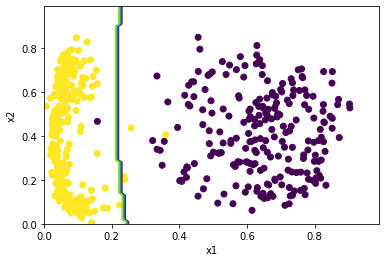

In [21]:
xx, yy = np.meshgrid(np.arange(0, 1, .01), np.arange(0, 1, .01))
Z = MLclf(train2d_x, train_y, np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure()
plt.contour(xx, yy, Z)
plt.scatter(train2d_x[:500, 0], train2d_x[:500, 1], c=train_y[:500])
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

1.6. Finding the prior probabilities for the two classes

In [27]:
def prior_probs(y):
    p_0 = (y == 0).sum()/y.shape[0]
    p_1 = (y == 1).sum()/y.shape[0]
    return p_0, p_1

1.6. Maximum a Posteriori classifier (Bayesian)

MAP and ML are essentially the same, except that the MAP rule further rescales the class shape based on the class prior probability.

We can conclude that in our case prior probabilities are not significant (data is not imbalanced),  $ \begin{equation} \ln(P(c1)) - \ln(P(c0)) \approx 0 \end{equation}$

That is why we got the exactly same error as the one of MLclf.

In [94]:
def MAPclf(train, train_labels, test, params=gauss_params, prior_probs = prior_probs):
    c0 = train[train_labels == 0]
    c1 = train[train_labels == 1]

    n = c0.shape[1]
    mu0, sigma0 = gauss_params(c0)
    mu1, sigma1 = gauss_params(c1)

    y_pred = []
    p_0, p_1 = prior_probs(train_labels)
    thr = np.log(p_1) - np.log(p_0)
    print("Threshold for MAP clf: ", thr)

    for x in test:
      c0 = (x-mu0)[:, None]
      pdf0 = -np.log(np.linalg.det(sigma0)) - c0.T@np.linalg.inv(sigma0)@c0

      c1 = (x-mu1)[:, None]
      pdf1 = -np.log(np.linalg.det(sigma1)) - c1.T@np.linalg.inv(sigma1)@c1

      if pdf0 - pdf1 > thr:
        y_pred.append(0)
      else:
        y_pred.append(1)

    return np.asarray(y_pred)

In [40]:
pred = MAPclf(train2d_x, train_y, test2d_x)
error(test_y, pred)

Threshold for MAP clf:  0.12951353951704092


0.0037825059101654845

In [41]:
compute_confusion_matrix(test_y, pred).astype(int)

array([[ 979,    1],
       [   7, 1128]])

1.7. Considering the results for MAP and ML classifiers with MED and GED classifiers from the previous assignment, we can say that we got better results from probabilistic models (from confusion matrix and prediction error).
The reason must be that the underlying distribution of our data is close to Gaussian, and parametric estimation gave good results.

### Exercise 2: Parametric Estimation with Multiple Distributions

In [67]:
train1d_x, test1d_x = transform(train_set_x, test_set_x, n_pca = 1, scale = True)
print(train1d_x.shape, train_y.shape, test1d_x.shape, test_y.shape)

(12665, 1) (12665,) (2115, 1) (2115,)


MLclf on Gaussian and exponential distributions give the same metric in 1d case, as in first task

In [100]:
pred1 = MLclf(train1d_x, train_y, test1d_x, params=gauss_params)
error(test_y, pred1)

0.0037825059101654845

In [101]:
def MLclf_exp(train, train_labels, test):
    c0 = train[train_labels == 0]
    c1 = train[train_labels == 1]

    m = c0.shape[0]
    lambda0 = m/np.sum(c0.squeeze(), axis=0)
    lambda1 = m/np.sum(c1.squeeze(), axis=0)

    y_pred = []
    for x in test.squeeze():
      pdf0 = np.log(lambda0) - lambda0*x

      pdf1 = np.log(lambda1) - lambda1*x
      
      if pdf0 - pdf1 > 0:
        y_pred.append(0)
      else:
        y_pred.append(1)

    return np.asarray(y_pred)

In [102]:
pred2 = MLclf_exp(train1d_x, train_y, test1d_x)
error(test_y, pred2)

0.0037825059101654845

In [116]:
def MLclf_uniform(train, train_labels, test, params=gauss_params):
    c0 = train[train_labels == 0]
    c1 = train[train_labels == 1]

    a0 = c0.min()
    b0 = c0.max()
    a1 = c1.min()
    b1 = c1.max()

    y_pred = []
    for x in test.squeeze():
      pdf0 = 0
      if a0<x<b0:
        pdf0 = 1/(b0-a0)

      pdf1 = 0
      if a1<x<b1:
        pdf1 = 1/(b1-a1)

      if pdf0 - pdf1 > 0:
        y_pred.append(0)
      else:
        y_pred.append(1)

    return np.asarray(y_pred)

In [117]:
pred3 = MLclf_uniform(train1d_x, train_y, test1d_x)
error(test_y, pred3)

0.023167848699763592

It looks like the distribution of our feature might be a mixture of Gaussian distributions or/and exponential distribution - that is why MLclf with exponential pdf gave result similar to the one with Gaussian. We can say that both these distribution can be used for parametric learning in our case.

ML clf on uniform distribution turned out to give a bit worse prediction - we can see on a histogram that our data is far from being uniformly distributed.

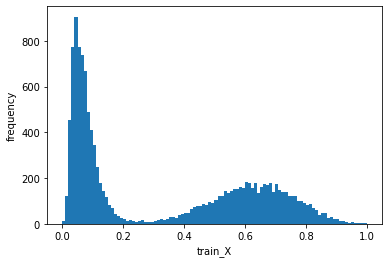

In [104]:
plt.hist(train1d_x, 100)
plt.xlabel("train_X")
plt.ylabel("frequency")
plt.show() 

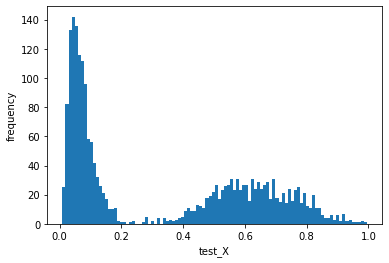

In [105]:
plt.hist(test1d_x, 100)
plt.xlabel("test_X")
plt.ylabel("frequency")
plt.show() 